# **CHB-MIT EEG Seizure Detection (Window-level Classification)**

## 1. Goal
This notebook builds a machine learning pipeline to detect seizure vs. non-seizure activity from raw EEG recordings of a single subject (chb01).

- Objective: Classify each short EEG window as seizure (1) or non-seizure (0).
- Task Type: Binary classification.
- Input (X): Raw EEG time-series windows (we segment the continuous signal into fixed-length windows).
- Label (y): Window labels generated from seizure annotations:
  - `y = 1` if the window overlaps a seizure interval
  - `y = 0` otherwise
- Models Compared:
  1. Logistic Regression
  2. Linear SVM


## 2. Dataset
- Dataset name: CHB-MIT Scalp EEG Database (subject `chb01`) [1]
- Modality: Raw EEG time-series (multi-channel scalp voltage recordings)
- Source: Kaggle (https://www.kaggle.com/datasets/abhishekinnvonix/seizure-epilepcy-chb-mit-eeg-dataset-pediatric/data)
- Files: `chb01_*.edf`
- Files used: A subset of 7 EDF recordings from chb01 that contain annotated seizure events (to ensure availability of positive samples).
- Sampling rate: 256 Hz
- Channels: 23 EEG channel derivations are available in each EDF file
- Channel used (baseline): We start with a single channel (F7–T7) to reduce computation.This is an engineering simplification.
- Windowing: The continuous signal is segmented into fixed-length windows (e.g., 4 seconds per window).
- Sample unit: one EEG window (from the selected channel)
- Label unit: one binary label per window:
  - `1` = seizure (the window overlaps an annotated seizure interval)
  - `0` = non-seizure





## 3. Imports

In [1]:
!pip -q install mne


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: C:\Users\harry\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path

# Signal processing
from scipy.signal import welch

# ML
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix, classification_report

# EDF reader
import mne

# Reproducibility (models only; we will NOT shuffle time order for splitting)
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

## 4. Select files and check one EDF
We first choose a small set of EDF files (here: all 7 seizure files for chb01).

Then we load one EDF to confirm the sampling rate and the name of Channel 2.

In [4]:
# Local path
DATA_DIR = Path("chb01") 

# Files to use (all seizure files from chb01-summary)
USE_FILES = [
    "chb01_03.edf", "chb01_04.edf", "chb01_15.edf", "chb01_16.edf",
    "chb01_18.edf", "chb01_21.edf", "chb01_26.edf"
]
edf_paths = [DATA_DIR / f for f in USE_FILES]
print("Using:", [p.name for p in edf_paths])

# Check: load one EDF
raw = mne.io.read_raw_edf(str(edf_paths[0]))
print("sfreq:", raw.info["sfreq"])
print("Channel 2 name:", raw.ch_names[1])  # channel 2

Using: ['chb01_03.edf', 'chb01_04.edf', 'chb01_15.edf', 'chb01_16.edf', 'chb01_18.edf', 'chb01_21.edf', 'chb01_26.edf']
Extracting EDF parameters from chb01\chb01_03.edf...
Setting channel info structure...
Creating raw.info structure...
sfreq: 256.0
Channel 2 name: F7-T7


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4068355209.py:13: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_paths[0]))


## 5. Manually define seizure intervals

We manually define seizure intervals (in seconds) from chb01-summary.txt.
These intervals will be used to assign a binary label to each 4-second window.

In [5]:
# Seizure intervals from chb01-summary.txt (seconds within each EDF file)
seizure_map = {
    "chb01_03.edf": [(2996, 3036)],
    "chb01_04.edf": [(1467, 1494)],
    "chb01_15.edf": [(1732, 1772)],
    "chb01_16.edf": [(1015, 1066)],
    "chb01_18.edf": [(1720, 1810)],
    "chb01_21.edf": [(327, 420)],
    "chb01_26.edf": [(1862, 1963)],
}

# quick check
for p in edf_paths:
    print(p.name, "->", seizure_map.get(p.name, []))

chb01_03.edf -> [(2996, 3036)]
chb01_04.edf -> [(1467, 1494)]
chb01_15.edf -> [(1732, 1772)]
chb01_16.edf -> [(1015, 1066)]
chb01_18.edf -> [(1720, 1810)]
chb01_21.edf -> [(327, 420)]
chb01_26.edf -> [(1862, 1963)]


## 6. Load EDF, take Channel 2, window into 4s samples, and create labels

For each EDF file, we extract Channel 2 (index 1), split it into 4-second windows, and label each window as seizure (1) if it overlaps the seizure interval, otherwise 0.

In [6]:
FS = 256
WINDOW_SEC = 4
STRIDE_SEC = 4

W_list, y_list = [], []
eda_rows = []

for edf_path in edf_paths:
    raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)
    raw.pick("eeg")
    raw.resample(FS)

    x = raw.get_data()[1]  # Channel 2 (index 1)
    win = WINDOW_SEC * FS
    step = STRIDE_SEC * FS
    starts = np.arange(0, len(x) - win + 1, step)

    intervals = seizure_map.get(edf_path.name, [])

    for s_idx in starts:
        t0 = s_idx / FS
        t1 = (s_idx + win) / FS

        # label by overlap
        y = 0
        for (ss, ee) in intervals:
            if (t0 < ee) and (t1 > ss):
                y = 1
                break

        w = x[s_idx:s_idx+win]          # full window (1024)
        W_list.append(w)
        y_list.append(y)

        # small EDA row: first 10 samples only
        eda_rows.append({
            "file": edf_path.name,
            "t0_sec": t0,
            "t1_sec": t1,
            "label": y,
            "x0": w[0], "x1": w[1], "x2": w[2], "x3": w[3], "x4": w[4],
            "x5": w[5], "x6": w[6], "x7": w[7], "x8": w[8], "x9": w[9],
        })

W = np.vstack(W_list)       # (N_windows, 1024)
y = np.array(y_list)        # (N_windows,)
df_eda = pd.DataFrame(eda_rows).reset_index(drop=True)

print("W shape:", W.shape)
print("Positive rate:", y.mean())
df_eda.iloc[745:754]


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.


C:\Users\harry\AppData\Local\Temp\ipykernel_23840\4267376175.py:9: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(str(edf_path), preload=True, verbose=False)


Sampling frequency of the instance is already 256.0, returning unmodified.
W shape: (5981, 1024)
Positive rate: 0.019227553920749037


,file,t0_sec,t1_sec,label,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9
745,chb01_03.edf,2980.0,2984.0,0,0.000013,0.000011,0.000008,2.930403e-06,-0.000002,-0.000008,-0.000011,-1.230769e-05,-0.000012,-0.000012
746,chb01_03.edf,2984.0,2988.0,0,0.000004,0.000004,0.000004,4.102564e-06,0.000001,-0.000002,-0.000001,-9.768010e-07,-0.000003,-0.000005
747,chb01_03.edf,2988.0,2992.0,0,0.000038,0.000038,0.000038,4.004884e-05,0.000038,0.000036,0.000037,3.614164e-05,0.000031,0.000028
748,chb01_03.edf,2992.0,2996.0,0,-0.000011,-0.000003,0.000007,1.699634e-05,0.000020,0.000022,0.000028,3.145299e-05,0.000032,0.000033
749,chb01_03.edf,2996.0,3000.0,1,0.000046,0.000051,0.000059,6.427350e-05,0.000058,0.000051,0.000046,3.926740e-05,0.000031,0.000027
750,chb01_03.edf,3000.0,3004.0,1,-0.000013,-0.000020,-0.000019,-2.481074e-05,-0.000012,-0.000010,-0.000007,-6.446886e-06,-0.000010,-0.000015
751,chb01_03.edf,3004.0,3008.0,1,-0.000029,-0.000014,-0.000055,-6.036630e-05,-0.000019,-0.000046,-0.000033,-6.056166e-06,-0.000077,-0.000051
752,chb01_03.edf,3008.0,3012.0,1,0.000012,0.000015,0.000010,6.446886e-06,0.000023,0.000047,0.000045,2.793651e-05,0.000009,-0.000016
753,chb01_03.edf,3012.0,3016.0,1,-0.000006,0.000002,0.000003,1.953602e-07,0.000012,0.000021,0.000039,6.661783e-05,0.000090,0.000099


## 7. Extract features for each 4s window

We convert each raw 4-second EEG window into a small feature vector so that classical ML models (Logistic Regression and Linear SVM) can train efficiently.

For each window, we estimate the power spectral density (PSD) using Welch’s method. [3] Then compute average band power in standard EEG frequency bands: delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–12 Hz), and beta (12–30 Hz). [4] We also include a few simple time-domain statistics (mean and standard deviation) to capture basic signal amplitude and variability.

These features summarize the main spectral content of the EEG while keeping the input dimension small and the pipeline fast.

In [10]:
from scipy.signal import welch

def bandpower(psd, freqs, fmin, fmax):
    m = (freqs >= fmin) & (freqs <= fmax)
    return np.trapezoid(psd[m], freqs[m])

X_list = []
for w in W:
    f_mean = np.mean(w)
    f_std  = np.std(w)

    freqs, psd = welch(w, fs=FS, nperseg=256)
    p_delta = bandpower(psd, freqs, 0.5, 4)
    p_theta = bandpower(psd, freqs, 4, 8)
    p_alpha = bandpower(psd, freqs, 8, 12)
    p_beta  = bandpower(psd, freqs, 12, 30)

    X_list.append([f_mean, f_std, p_delta, p_theta, p_alpha, p_beta])

X = np.array(X_list)
feature_names = ["mean","std","delta","theta","alpha","beta"]
print("X shape:", X.shape)

X shape: (5981, 6)


## 8. EDA — Compare Delta/Theta/Alpha/Beta bandpower (log scale)
Bandpowers are usually very skewed, and seizure windows are rare, so we plot log10(power) for each band and compare y=0 vs y=1

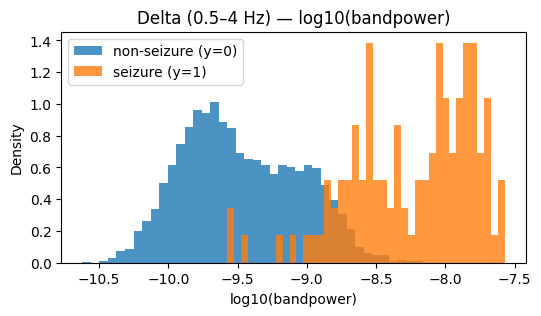

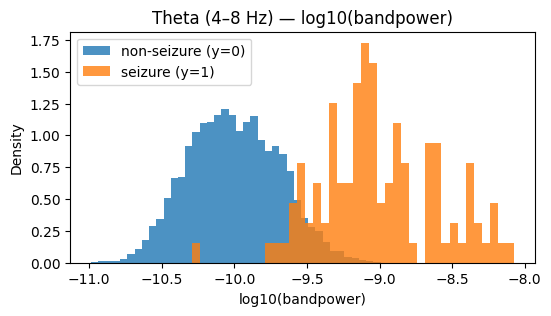

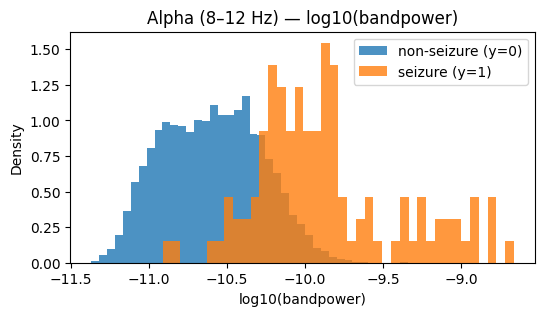

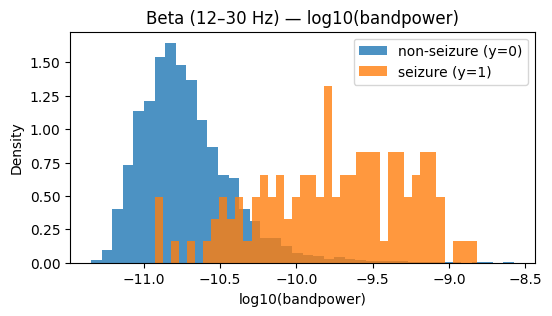

In [11]:
band_cols = {
    "Delta (0.5–4 Hz)": 2,
    "Theta (4–8 Hz)": 3,
    "Alpha (8–12 Hz)": 4,
    "Beta (12–30 Hz)": 5,
}

for band_name, col in band_cols.items():
    p = X[:, col]
    p_log = np.log10(p + 1e-12)

    plt.figure(figsize=(6, 3))
    plt.hist(p_log[y == 0], bins=40, density=True, alpha=0.8, label="non-seizure (y=0)")
    plt.hist(p_log[y == 1], bins=40, density=True, alpha=0.8, label="seizure (y=1)")
    plt.title(f"{band_name} — log10(bandpower)")
    plt.xlabel("log10(bandpower)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()

## 9. Train/Test Split (time order)
We keep windows in chronological order and hold out the last 20% as the test set. This prevents leakage (using “future” windows to predict the “past”).

In [12]:
N = len(y)
split = int(0.8 * N)

X_train, y_train = X[:split], y[:split]
X_test,  y_test  = X[split:], y[split:]

print("Train:", X_train.shape, "seizure_ratio =", y_train.mean())
print("Test: ", X_test.shape,  "seizure_ratio =", y_test.mean())

Train: (4784, 6) seizure_ratio = 0.018603678929765888
Test:  (1197, 6) seizure_ratio = 0.02172096908939014


## 10. Method 1: Logistic Regression + Final Test

We train a Logistic Regression classifier using engineered EEG features. [2]
Hyperparameter C is tuned with time-series cross-validation to avoid leakage.

We use TimeSeriesSplit (4 splits), which creates 5 consecutive time blocks and performs walk-forward validation:
train on blocks [1], validate on [2]; train on [1–2], validate on [3]; train on [1–3], validate on [4]; train on [1–4], validate on [5].

In [13]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report

C_list = [0.01, 0.1, 1, 10, 100]


best_C = None
best_macro_f1 = -1
tuning_results = []

cv = TimeSeriesSplit(n_splits=4)

for C in C_list:
    fold_acc = []
    fold_f1 = []

    for tr_idx, va_idx in cv.split(X_train):
        X_train_fold, y_train_fold = X_train[tr_idx], y_train[tr_idx]
        X_val_fold,   y_val_fold   = X_train[va_idx], y_train[va_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled   = scaler.transform(X_val_fold)

        clf = LogisticRegression(
            C=C,
            penalty="l2",
            max_iter=20000,
            random_state=RANDOM_STATE
        )
        clf.fit(X_train_scaled, y_train_fold)
        val_pred = clf.predict(X_val_scaled)

        fold_acc.append(accuracy_score(y_val_fold, val_pred))
        fold_f1.append(f1_score(y_val_fold, val_pred, average="macro"))

    acc = float(np.mean(fold_acc))
    macro_f1 = float(np.mean(fold_f1))
    tuning_results.append((C, acc, macro_f1))

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_C = C

print("Tuning results (C, CV_acc, CV_macro_f1):")
for C, acc, mf1 in tuning_results:
    print(f"C={C:>6}  acc={acc:.4f}  macro_f1={mf1:.4f}")

print("\nBest C:", best_C, "Best CV macro F1:", best_macro_f1)

Tuning results (C, CV_acc, CV_macro_f1):
C=  0.01  acc=0.9911  macro_f1=0.7793
C=   0.1  acc=0.9914  macro_f1=0.8146
C=     1  acc=0.9908  macro_f1=0.7962
C=    10  acc=0.9903  macro_f1=0.7910
C=   100  acc=0.9903  macro_f1=0.7910

Best C: 0.1 Best CV macro F1: 0.8145631840102769


C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(
C:\Users\harry

Refit on all training data with best C, then test once

In [14]:
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled  = scaler_final.transform(X_test)

final_clf = LogisticRegression(
    C=best_C,
    penalty="l2",
    max_iter=20000,
    random_state=RANDOM_STATE
)
final_clf.fit(X_train_scaled, y_train)

test_pred_lr = final_clf.predict(X_test_scaled)

lr_test_acc = accuracy_score(y_test, test_pred_lr)
lr_test_f1  = f1_score(y_test, test_pred_lr, average="macro")
lr_cm = confusion_matrix(y_test, test_pred_lr)

print("Final Logistic Regression Test Accuracy:", lr_test_acc)
print("Final Logistic Regression Test Macro F1:", lr_test_f1)
print("\nConfusion Matrix (Test):\n", lr_cm)
print("\nClassification Report (Test):\n", classification_report(y_test, test_pred_lr, digits=4))

Final Logistic Regression Test Accuracy: 0.9832915622389307
Final Logistic Regression Test Macro F1: 0.8441893158388004

Confusion Matrix (Test):
 [[1154   17]
 [   3   23]]

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9974    0.9855    0.9914      1171
           1     0.5750    0.8846    0.6970        26

    accuracy                         0.9833      1197
   macro avg     0.7862    0.9350    0.8442      1197
weighted avg     0.9882    0.9833    0.9850      1197



C:\Users\harry\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\sklearn\linear_model\_logistic.py:1135: FutureWarning: 'penalty' was deprecated in version 1.8 and will be removed in 1.10. To avoid this warning, leave 'penalty' set to its default value and use 'l1_ratio' or 'C' instead. Use l1_ratio=0 instead of penalty='l2', l1_ratio=1 instead of penalty='l1', and C=np.inf instead of penalty=None.
  warnings.warn(


## 11. Method 2: Linear SVM + Final Test

We use TimeSeriesSplit (4 splits) to perform walk-forward validation on the training set, tune C, then refit on all training data and evaluate once on the held-out test set. [2]

In [15]:
C_list = [1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10]

best_C = None
best_macro_f1 = -1
tuning_results = []

cv = TimeSeriesSplit(n_splits=4)

for C in C_list:
    fold_acc = []
    fold_f1 = []

    for tr_idx, va_idx in cv.split(X_train):
        X_train_fold, y_train_fold = X_train[tr_idx], y_train[tr_idx]
        X_val_fold,   y_val_fold   = X_train[va_idx], y_train[va_idx]

        scaler = StandardScaler()
        X_train_scaled = scaler.fit_transform(X_train_fold)
        X_val_scaled   = scaler.transform(X_val_fold)

        clf = LinearSVC(
            C=C,
            random_state=RANDOM_STATE,
            max_iter=20000
        )
        clf.fit(X_train_scaled, y_train_fold)
        val_pred = clf.predict(X_val_scaled)

        fold_acc.append(accuracy_score(y_val_fold, val_pred))
        fold_f1.append(f1_score(y_val_fold, val_pred, average="macro"))

    acc = float(np.mean(fold_acc))
    macro_f1 = float(np.mean(fold_f1))
    tuning_results.append((C, acc, macro_f1))

    if macro_f1 > best_macro_f1:
        best_macro_f1 = macro_f1
        best_C = C

print("Tuning results (C, CV_acc, CV_macro_f1):")
for C, acc, mf1 in tuning_results:
    print(f"C={C:>8}  acc={acc:.4f}  macro_f1={mf1:.4f}")

print("\nBest C:", best_C, "Best CV macro F1:", best_macro_f1)

Tuning results (C, CV_acc, CV_macro_f1):
C=   1e-05  acc=0.9901  macro_f1=0.8232
C=  0.0001  acc=0.9919  macro_f1=0.8240
C=   0.001  acc=0.9906  macro_f1=0.7799
C=    0.01  acc=0.9916  macro_f1=0.8050
C=     0.1  acc=0.9911  macro_f1=0.7944
C=       1  acc=0.9911  macro_f1=0.8053
C=      10  acc=0.9911  macro_f1=0.8053

Best C: 0.0001 Best CV macro F1: 0.823968823738886


Refit on all training data with best C, then test once

In [16]:
scaler_final = StandardScaler()
X_train_scaled = scaler_final.fit_transform(X_train)
X_test_scaled  = scaler_final.transform(X_test)

final_clf = LinearSVC(
    C=best_C,
    random_state=RANDOM_STATE,
    max_iter=20000
)
final_clf.fit(X_train_scaled, y_train)

test_pred_svm = final_clf.predict(X_test_scaled)

svm_test_acc = accuracy_score(y_test, test_pred_svm)
svm_test_f1  = f1_score(y_test, test_pred_svm, average="macro")
svm_cm = confusion_matrix(y_test, test_pred_svm)

print("Final Linear SVM Test Accuracy:", svm_test_acc)
print("Final Linear SVM Test Macro F1:", svm_test_f1)
print("\nConfusion Matrix (Test):\n", svm_cm)
print("\nClassification Report (Test):\n", classification_report(y_test, test_pred_svm, digits=4))


Final Linear SVM Test Accuracy: 0.9908103592314118
Final Linear SVM Test Macro F1: 0.9011553273427471

Confusion Matrix (Test):
 [[1163    8]
 [   3   23]]

Classification Report (Test):
               precision    recall  f1-score   support

           0     0.9974    0.9932    0.9953      1171
           1     0.7419    0.8846    0.8070        26

    accuracy                         0.9908      1197
   macro avg     0.8697    0.9389    0.9012      1197
weighted avg     0.9919    0.9908    0.9912      1197



## 12. Comparative Analysis (Logistic Regression vs. Linear SVM)

We compare two classifiers on the same held-out time-ordered test set (last 20% of windows). Because seizure windows are rare, we report macro F1 and the confusion matrix in addition to accuracy.

Test-set results:
- Logistic Regression: Accuracy = 0.9833, Macro F1 = 0.8442, FP = 17, FN = 3
- Linear SVM: Accuracy = 0.9908, Macro F1 = 0.9012, FP = 8, FN = 3

Both models achieve the same seizure recall (23/26 = 0.8846), but Linear SVM produces fewer false alarms (8 vs. 17), leading to much higher seizure precision (0.7419 vs. 0.5750) and higher macro F1. Therefore, Linear SVM is the recommended model for this dataset.


Metrics table:

In [17]:
summary_df = pd.DataFrame({
    "Model": ["Logistic Regression", "Linear SVM"],
    "Test Accuracy": [lr_test_acc, svm_test_acc],
    "Test Macro-F1": [lr_test_f1, svm_test_f1],
})
display(summary_df)

,Model,Test Accuracy,Test Macro-F1
0,Logistic Regression,0.983292,0.844189
1,Linear SVM,0.990810,0.901155


Bar chart:

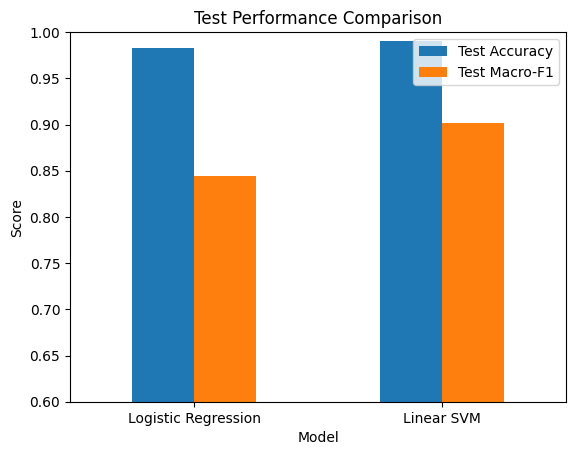

In [18]:
ax = summary_df.set_index("Model")[["Test Accuracy", "Test Macro-F1"]].plot(kind="bar")
ax.set_title("Test Performance Comparison")
ax.set_ylabel("Score")
ax.set_ylim(0.6, 1.0)
plt.xticks(rotation=0)
plt.show()

Confusion matrices

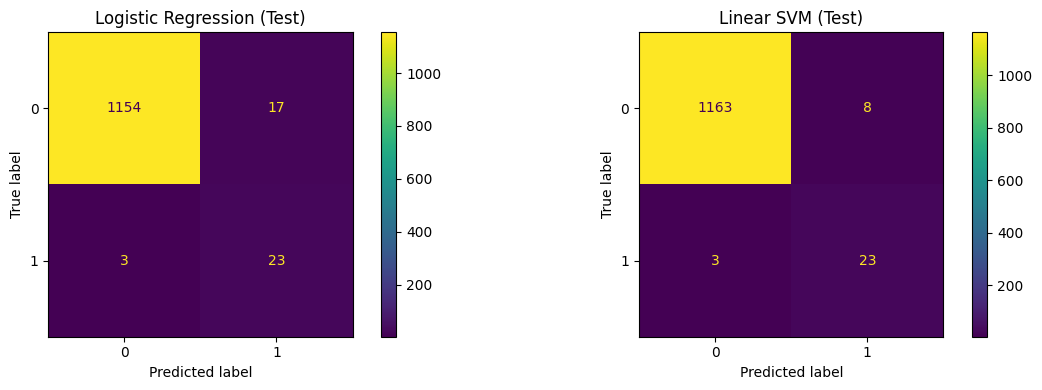

In [19]:
from sklearn.metrics import ConfusionMatrixDisplay

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

ConfusionMatrixDisplay(confusion_matrix=lr_cm).plot(ax=axes[0], values_format="d")
axes[0].set_title("Logistic Regression (Test)")

ConfusionMatrixDisplay(confusion_matrix=svm_cm).plot(ax=axes[1], values_format="d")
axes[1].set_title("Linear SVM (Test)")

plt.tight_layout()
plt.show()

## 13. Conclusion

Both models achieve high overall accuracy due to strong class imbalance, so macro-F1 and the confusion matrix are more informative. Linear SVM achieves higher test macro-F1 and substantially fewer false positives while keeping seizure recall similar to Logistic Regression.

We recommend Linear SVM as the final model for this subject-specific seizure-window classification task.

## 13. Ethical Considerations

- Clinical risk (false alarms vs. missed seizures): A false alarm (predict seizure when it is not) can cause stress and unnecessary actions. A missed seizure can be dangerous. So we report precision/recall, not only accuracy.

- EEG privacy: EEG is sensitive health data and can reveal personal information. The data and results should be stored and shared carefully.

- Limited generalization. This model is trained on one patient (chb01). It may not work well for other patients without re-training or calibration.



## 14. Bibliography

[1] CHB-MIT Scalp EEG Database (PhysioNet).  
[2] Scikit-learn Documentation: LogisticRegression and LinearSVC.  
[3] SciPy Documentation: scipy.signal.welch (Welch PSD).  
[4] EEG frequency bands (delta/theta/alpha/beta): Wikipedia